# Custom Models with synloc: Using Copulas for Synthetic Data Generation

The `synloc` package empowers users to create synthetic datasets by leveraging custom statistical distributions. While `synloc` supports a wide range of parametric and nonparametric models, one of the most powerful and flexible approaches is the use of copulas—statistical tools that model complex dependencies between variables.

**What does this notebook demonstrate?**

- Build and use custom synthetic data generators in `synloc`.
- How to extend `synloc` with your own custom distribution classes, using both k-nearest-neighbor and clustering-based resampling strategies.
- How to integrate copula-based models (specifically, Gaussian copulas via the `synthia` package) into the `synloc` framework to generate realistic synthetic data that preserves multivariate relationships.
- Guidance on best practices for subclassing `kNNResampler` and `clusterResampler` to implement your own synthetic data generation logic.


## The custom model template for `kNNResampler`

Here is the template to utilise `kNN Resampler`:

```python
from .kNNResampler import kNNResampler
from .tools import stochastic_rounder
from pandas import DataFrame

class myDistributionWithkNN(kNNResampler):
    """
    Base class for k‐nearest‐neighbor synthetic data generators.
    
    :param data: Original dataset to synthesize from
    :type data: pandas.DataFrame
    :param K: Number of neighbors for each synthetic draw (default: 30)
    :type K: int, optional
    :param normalize: Whether to normalize before neighbor search (default: True)
    :type normalize: bool, optional
    :param clipping: Clip outputs to the original data range (default: True)
    :type clipping: bool, optional
    :param Args_NearestNeighbors: Extra kwargs for sklearn.neighbors.NearestNeighbors
    :type Args_NearestNeighbors: dict, optional
    """
    def __init__(
        self,
        data: DataFrame,
        K: int = 30,
        normalize: bool = True,
        clipping: bool = True,
        n_jobs: int = -1,
        Args_NearestNeighbors: dict = {}
    ):
        super().__init__(data, self.method, K, normalize, clipping, n_jobs, Args_NearestNeighbors)

    def method(self, subsample: DataFrame):
        """
        Abstract method: generate a single synthetic sample from a kNN subsample.

        :param subsample: DataFrame of the K nearest neighbors
        :type subsample: pandas.DataFrame
        :return: One synthetic observation (array-like or pandas.Series)
        """
        raise NotImplementedError("Subclasses must implement `method`")

    def round_integers(
        self,
        integer_columns: list,
        stochastic: bool = True
    ) -> None:
        """
        Round specified columns of the generated sample to integers.

        :param integer_columns: List of column names to round
        :type integer_columns: list of str
        :param stochastic: If True, use stochastic rounding; else deterministic
        :type stochastic: bool, optional
        """
        if not self.fitted:
            print("No synthetic data yet—call `.fit()` first.")
            return

        # Leverage parent’s rounding routine
        super().round_integers(integer_columns, stochastic)
```

Let's install a python package named `synthia` to use their copulas:

In [2]:
from synloc import kNNResampler, sample_circulars_xy
from synloc.tools import stochastic_rounder
from synthia import GaussianCopula, CopulaDataGenerator
from pandas import DataFrame


Applying the template above using `GaussianCopula` and `CopulaDataGenerator` methods. See `synthia` package for further explanations for the usage of these distributions. 

In [3]:
class kNNCopula(kNNResampler):
    """
    Base class for k‐nearest‐neighbor synthetic data generators.
    
    :param data: Original dataset to synthesize from
    :type data: pandas.DataFrame
    :param K: Number of neighbors for each synthetic draw (default: 30)
    :type K: int, optional
    :param normalize: Whether to normalize before neighbor search (default: True)
    :type normalize: bool, optional
    :param clipping: Clip outputs to the original data range (default: True)
    :type clipping: bool, optional
    :param Args_NearestNeighbors: Extra kwargs for sklearn.neighbors.NearestNeighbors
    :type Args_NearestNeighbors: dict, optional
    """
    def __init__(
        self,
        data: DataFrame,
        K: int = 30,
        normalize: bool = True,
        clipping: bool = True,
        n_jobs: int = -1,
        Args_NearestNeighbors: dict = {}
    ):
        super().__init__(data, self.method, K, normalize, clipping, n_jobs, Args_NearestNeighbors)

    def round_integers(self, integer_columns:list, stochastic:bool = True):
        """Rounds variables to integers. 

        :param integer_columns: The list of variables to be rounded.
        :type integer_columns: list
        :param stochastic: Variables are rounded by a stochastic process, defaults to True
        :type stochastic: bool, optional
        """ 
        if self.fitted:
            if stochastic:
                self.synthetic.loc[:, integer_columns] = stochastic_rounder(self.synthetic.loc[:, integer_columns])
            else:
                self.synthetic.loc[:, integer_columns] = self.synthetic.loc[:, integer_columns].round()
        else: 
            print('The synthetic sample is not created yet. Use `.fit()` to create synthetic sample.')
    
    def method(self, subsample:DataFrame):
        """Creating synthetic values using Gaussian copula.

        :param subsample: A subsample defined by the `kNNResampler` class.
        :type subsample: pandas.DataFrame
        :return: Synthetic values. 
        :rtype: numpy.darray
        """  
        generator = CopulaDataGenerator()
        generator.fit(subsample, copula=GaussianCopula() ,parameterize_by=None)
        return generator.generate(1)[0]


Let's replicate the following 2d sample: encircled rings. 

<Axes: title={'center': 'Sampled Data'}, xlabel='x', ylabel='y'>

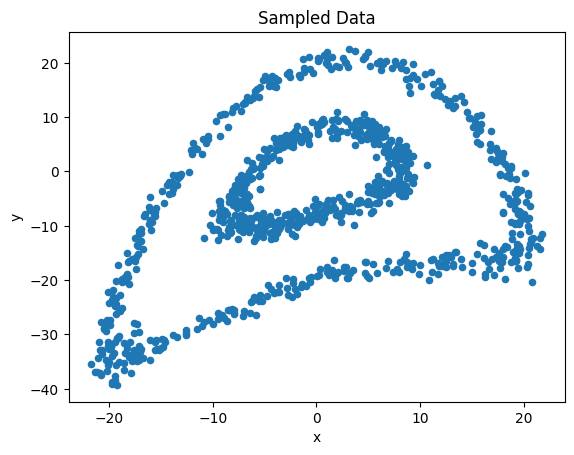

In [4]:
data = sample_circulars_xy(1000)
data.plot.scatter(x='x', y='y', title='Sampled Data')

In [5]:
syn1 = kNNCopula(data, K=20)
syn1.fit()

Generating 1000 synthetic samples using 16 cores...


Generating synthetic samples: 100%|██████████| 1000/1000 [00:15<00:00, 66.03it/s]

Synthetic sample generation complete.


x          y
0    -8.249489 -10.766477
1    -8.025780 -10.811976
2    -8.425689  -9.926674
3     1.125091 -19.019308
4    -7.716767 -23.919652
..         ...        ...
995  12.127823  15.212206
996  -5.146815  14.332660
997  -3.353717   4.440870
998   6.997454   3.682326
999   2.729220 -18.563244

[1000 rows x 2 columns]

Compare real and synthetic samples:

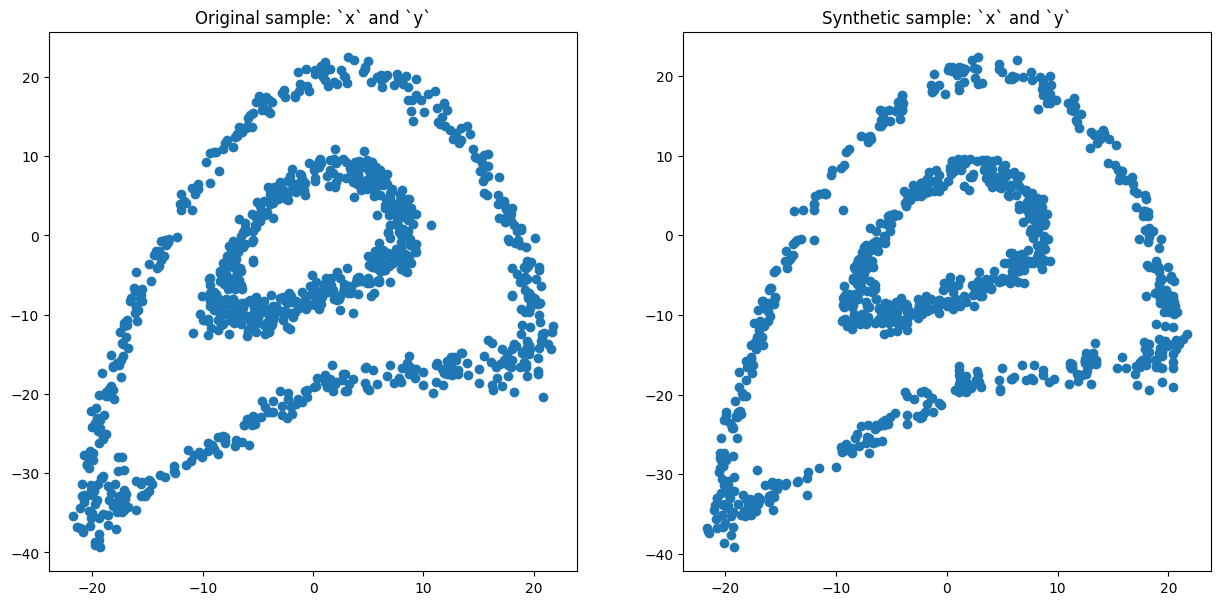

In [6]:
syn1.comparePlots(['x', 'y'])

## The custom model template for `clusterResampler`

Instead of `kNNResampler`, we will use `clusterResampler` algorithm. Here is the template for the `clusterResampler`:

```python
from .clusterResampler import clusterResampler
from pandas import DataFrame

class MyClusterResampler(clusterResampler):
    """
    Base class for cluster‐based synthetic data generators.
    
    :param data: Original dataset to synthesize from
    :type data: pandas.DataFrame
    :param n_clusters: Number of clusters to form (default: 8)
    :type n_clusters: int, optional
    :param size_min: Minimum cluster size to consider (default: None)
    :type size_min: int, optional
    :param normalize: Whether to normalize before clustering (default: True)
    :type normalize: bool, optional
    :param clipping: Clip outputs to the original data range (default: True)
    :type clipping: bool, optional
    """
    def __init__(
        self,
        data: DataFrame,
        n_clusters: int = 8,
        size_min: int = None,
        normalize: bool = True,
        clipping: bool = True
    ):
        super().__init__(
            data,
            method=self.method,
            n_clusters=n_clusters,
            size_min=size_min,
            normalize=normalize,
            clipping=clipping
        )

    def method(self, cluster: DataFrame, size: int):
        """
        Abstract method: generate synthetic samples for one cluster.
        
        :param cluster: DataFrame for a single cluster
        :type cluster: pandas.DataFrame
        :param size: Number of synthetic samples to produce
        :type size: int
        :return: Synthetic samples (DataFrame or array-like)
        """
        raise NotImplementedError("Subclasses must implement `method`")
```

Here is the implementation with gaussian copula:

In [7]:
from synloc import clusterResampler
from synthia import GaussianCopula, CopulaDataGenerator
from pandas import DataFrame

class clusterGaussCopula(clusterResampler):
    """`clusterGaussCopula` is a method for `clusterResampler` class to 
    create synthetic values from Gaussian copula. 
    
    :param data: Original data set to be synthesized
    :type data: pandas.DataFrame
    :param n_clusters: The number of clusters, defaults to 8
    :type n_clusters: int, optional
    :param size_min: Required minimum cluster size, defaults to None
    :type size_min: int, optional
    :param normalize: Normalize sample before defining clusters, defaults to True
    :type normalize: bool, optional
    :param clipping: trim values greater (smaller) than the maximum (minimum) for each variable, defaults to True
    :type clipping: bool, optional
    """ 
    def __init__(self, data:DataFrame, n_clusters=8, size_min:int = None, normalize:bool = True, clipping:bool = True) -> None:        
        super().__init__(data, method=self.method,n_clusters = n_clusters, size_min = size_min, normalize = normalize, clipping = clipping)
         
    def method(self, cluster:DataFrame, size:int):
        """Creating synthetic values from Gaussian copula. 

        :param cluster: Cluster data
        :type cluster: pandas.DataFrame
        :param size: Required number of synthetic observations. Size is equal to the number of observations in the cluster if not specified.
        :type size: int
        :return: Synthetic values
        :rtype: pandas.DataFrame
        """  
        generator = CopulaDataGenerator()
        generator.fit(cluster, copula=GaussianCopula() ,parameterize_by=None)
        syn_sample = DataFrame(generator.generate(size))
        syn_sample.columns = cluster.columns
        return syn_sample

Let's create synthetic version of `data` created above:

In [12]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

syn2 = clusterGaussCopula(data, n_clusters=30, size_min=8)
syn2.fit()


x          y
0   -5.232491  -7.443405
1   -7.279081  -8.143454
2   -5.760451  -8.030917
3   -5.148836  -8.521245
4   -8.403539 -10.668141
..        ...        ...
11  15.512784   6.989746
12  15.832936   7.487828
13  15.703754   7.305207
14  16.777673   7.482064
15  15.633184   5.319847

[1000 rows x 2 columns]

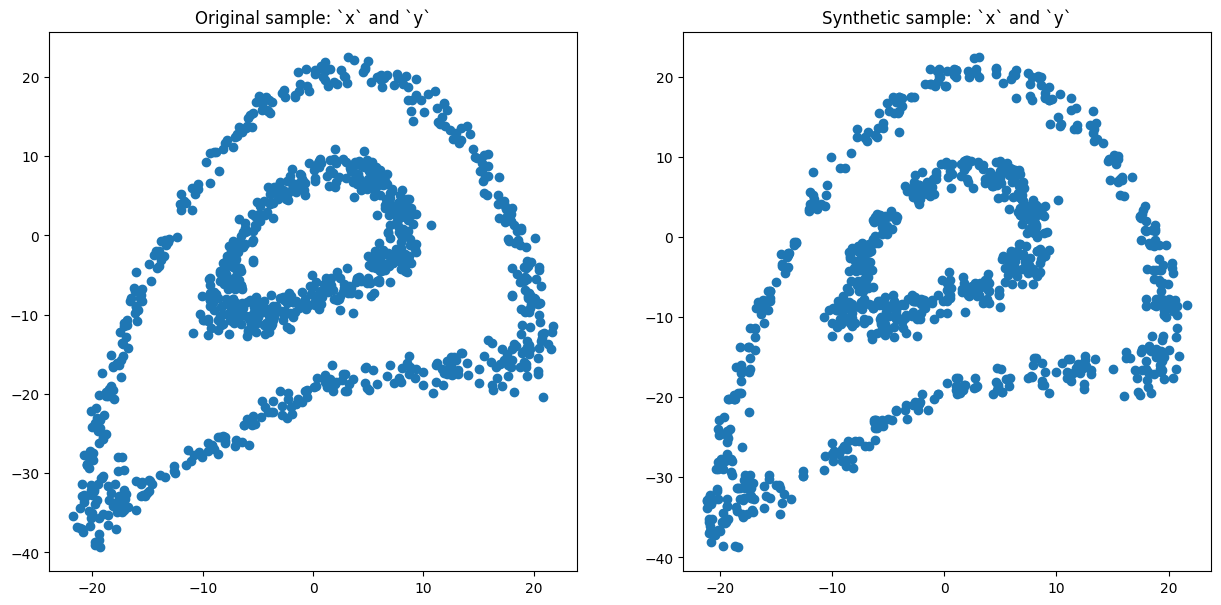

In [13]:
syn2.comparePlots(['x', 'y'])